In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [253]:
# helper 
# phonemize all sentences 
from phonemizer.backend import EspeakBackend
from phonemizer.backend.espeak.wrapper import EspeakWrapper
from phonemizer.separator import Separator

EspeakWrapper.set_library(
    "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
)

# initialize the espeak backend for English
backend = EspeakBackend("fr-fr")
separator = Separator(phone=" ", word=None)

def get_phonemes(text): 
    value = backend.phonemize([text], separator=separator, strip=True)

    phonemes = value[0].split(" ")
    
    return phonemes


In [254]:
# get pos tags for each word
import spacy 
from spacy_syllables import SpacySyllables  # noqa

model = "fr_core_news_lg"
if not spacy.util.is_package(model):
    import spacy.cli

    spacy.cli.download(model)  # type: ignore
nlp = spacy.load(model)
nlp.add_pipe("syllables", after="tok2vec")

In [255]:
content_function_word = {  # 1 content, 0 function, 2 others
    "ADJ": "content",
    "ADP": "function",
    "ADV": "content",
    "AUX": "function",
    "DET": "function",
    "NOUN": "content",
    "NUM": "function",
    "PRON": "function",
    "PROPN": "function",
    "VERB": "content",
    "INTJ": "function",
    "SCONJ": "function", 
    "CCONJ": "function", 
    "PUNCT": "function",
}


# sentence stats

In [384]:
sentences = pd.read_csv('../text/selection_min_rep3.csv')
sentences.head()

,Unnamed: 0,theme,type,structure,numer,tense,polarity,sentence,num_words,translation,words,num_words_translation,include_et,in_vocab,sum_word_counts_sent,lemmas,overlap
0,32424,basic,declarative,independent,singular,present,negative,You do not have to come if you don't want to\n,11,Tu n'es pas obligé de venir si tu ne veux pas.,"['tu', ""n'"", 'es', 'pas', 'obligé', 'de', 'ven...",12,False,True,489.000000,"['tu', 'ne', 'être', 'pas', 'obliger', 'de', '...",NaN
1,11310,basic,declarative,preposition,plural,present,negative,The students do not have their homework with t...,9,Les élèves n'ont pas leurs devoirs avec eux.,"['les', 'élèves', ""n'"", 'ont', 'pas', 'leurs',...",9,False,True,461.750000,"['le', 'élève', 'ne', 'avoir', 'pas', 'leur', ...",NaN
2,8312,food,declarative,independent,singular,present,negative,He is not avoiding chocolate because he dislik...,9,Il n'évite pas le chocolat parce qu'il ne l'ai...,"['il', ""n'"", 'évite', 'pas', 'le', 'chocolat',...",13,False,True,499.571429,"['il', 'ne', 'éviter', 'pas', 'le', 'chocolat'...",NaN
3,15645,housing,declarative,simple,singular,past,negative,I did not like the color of the furniture\n,9,Je n'aimais pas la couleur des meubles.,"['je', ""n'"", 'aimais', 'pas', 'la', 'couleur',...",8,False,True,457.750000,"['je', 'ne', 'aimer', 'pas', 'le', 'couleur', ...",NaN
4,34086,basic,declarative,simple,plural,past,negative,They had not finished their homework\n,6,Ils n'avaient pas fini leurs devoirs.,"['ils', ""n'"", 'avaient', 'pas', 'fini', 'leurs...",7,False,True,458.750000,"['il', 'ne', 'avoir', 'pas', 'finir', 'leur', ...",NaN


In [385]:
# get unique vocab 
def get_words_from_sentence(sentence):
    sentence = sentence.lower()
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct]
    num_words = len(words)
    return words

sentences['words'] = sentences['translation'].apply(get_words_from_sentence)
sentences.head()

,Unnamed: 0,theme,type,structure,numer,tense,polarity,sentence,num_words,translation,words,num_words_translation,include_et,in_vocab,sum_word_counts_sent,lemmas,overlap
0,32424,basic,declarative,independent,singular,present,negative,You do not have to come if you don't want to\n,11,Tu n'es pas obligé de venir si tu ne veux pas.,"[tu, n', es, pas, obligé, de, venir, si, tu, n...",12,False,True,489.000000,"['tu', 'ne', 'être', 'pas', 'obliger', 'de', '...",NaN
1,11310,basic,declarative,preposition,plural,present,negative,The students do not have their homework with t...,9,Les élèves n'ont pas leurs devoirs avec eux.,"[les, élèves, n', ont, pas, leurs, devoirs, av...",9,False,True,461.750000,"['le', 'élève', 'ne', 'avoir', 'pas', 'leur', ...",NaN
2,8312,food,declarative,independent,singular,present,negative,He is not avoiding chocolate because he dislik...,9,Il n'évite pas le chocolat parce qu'il ne l'ai...,"[il, n', évite, pas, le, chocolat, parce, qu',...",13,False,True,499.571429,"['il', 'ne', 'éviter', 'pas', 'le', 'chocolat'...",NaN
3,15645,housing,declarative,simple,singular,past,negative,I did not like the color of the furniture\n,9,Je n'aimais pas la couleur des meubles.,"[je, n', aimais, pas, la, couleur, des, meubles]",8,False,True,457.750000,"['je', 'ne', 'aimer', 'pas', 'le', 'couleur', ...",NaN
4,34086,basic,declarative,simple,plural,past,negative,They had not finished their homework\n,6,Ils n'avaient pas fini leurs devoirs.,"[ils, n', avaient, pas, fini, leurs, devoirs]",7,False,True,458.750000,"['il', 'ne', 'avoir', 'pas', 'finir', 'leur', ...",NaN


In [386]:
def lemmas(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if (token.pos_ not in ["SPACE", "PUNCT"])]

sentences['lemmas'] = sentences.translation.apply(lemmas)
sentences.head()

,Unnamed: 0,theme,type,structure,numer,tense,polarity,sentence,num_words,translation,words,num_words_translation,include_et,in_vocab,sum_word_counts_sent,lemmas,overlap
0,32424,basic,declarative,independent,singular,present,negative,You do not have to come if you don't want to\n,11,Tu n'es pas obligé de venir si tu ne veux pas.,"[tu, n', es, pas, obligé, de, venir, si, tu, n...",12,False,True,489.000000,"[tu, ne, être, pas, obliger, de, venir, si, tu...",NaN
1,11310,basic,declarative,preposition,plural,present,negative,The students do not have their homework with t...,9,Les élèves n'ont pas leurs devoirs avec eux.,"[les, élèves, n', ont, pas, leurs, devoirs, av...",9,False,True,461.750000,"[le, élève, ne, avoir, pas, leur, devoir, avec...",NaN
2,8312,food,declarative,independent,singular,present,negative,He is not avoiding chocolate because he dislik...,9,Il n'évite pas le chocolat parce qu'il ne l'ai...,"[il, n', évite, pas, le, chocolat, parce, qu',...",13,False,True,499.571429,"[il, ne, éviter, pas, le, chocolat, parce, que...",NaN
3,15645,housing,declarative,simple,singular,past,negative,I did not like the color of the furniture\n,9,Je n'aimais pas la couleur des meubles.,"[je, n', aimais, pas, la, couleur, des, meubles]",8,False,True,457.750000,"[je, ne, aimer, pas, le, couleur, de, meuble]",NaN
4,34086,basic,declarative,simple,plural,past,negative,They had not finished their homework\n,6,Ils n'avaient pas fini leurs devoirs.,"[ils, n', avaient, pas, fini, leurs, devoirs]",7,False,True,458.750000,"[il, ne, avoir, pas, finir, leur, devoir]",NaN


In [387]:
sentences.iloc[0].keys()

Index(['Unnamed: 0', 'theme', 'type', 'structure', 'numer', 'tense',
       'polarity', 'sentence', 'num_words', 'translation', 'words',
       'num_words_translation', 'include_et', 'in_vocab',
       'sum_word_counts_sent', 'lemmas', 'overlap'],
      dtype='object')

In [388]:
sentences.iloc[0][['sentence', 'translation']]

sentence       You do not have to come if you don't want to\n
translation    Tu n'es pas obligé de venir si tu ne veux pas.
Name: 0, dtype: object

array([<Axes: title={'center': 'declarative'}, ylabel='Frequency'>],
      dtype=object)

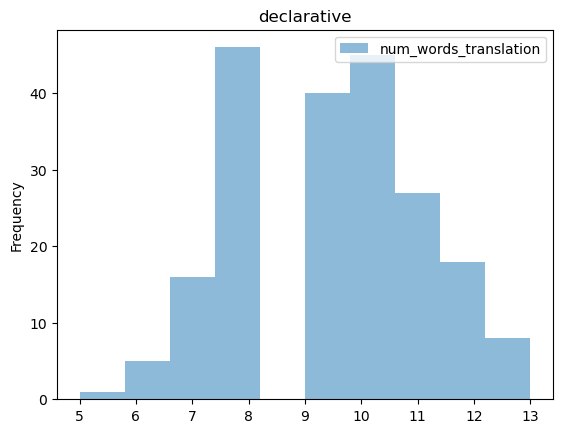

In [389]:
sentences[['type', 'num_words_translation']].plot.hist(by='type', bins=10, alpha=0.5)

In [390]:
len(sentences)

206

In [391]:
sentences.polarity.value_counts()

polarity
negative       110
affirmative     96
Name: count, dtype: int64

In [392]:
sentences.structure.value_counts()

structure
simple         56
cleft          49
preposition    46
dependent      29
independent    26
Name: count, dtype: int64

In [393]:
# subset[['type', 'translanted_num_words']].plot.hist(by='type', bins=10, alpha=0.5)
subset = sentences

In [394]:
pos_tags = []
word_id = []

def get_pos_tags(text): 
    doc = nlp(text)
    tags = [token.pos_ for token in doc if token.pos_ != "SPACE"]
    return tags, np.arange(len(tags))

for index, row in subset.iterrows():
    tags, id = get_pos_tags(row['translation'])
    pos_tags.append(tags)
    word_id.append(id)

pos_tags_df = pd.DataFrame({'id': np.concatenate(word_id), 'pos_tags': np.concatenate(pos_tags)})

pos_tags_df.head()

,id,pos_tags
0,0,ADV
1,1,ADV
2,2,AUX
3,3,ADV
4,4,VERB


Text(0.5, 1.0, 'pos percentage by word id')

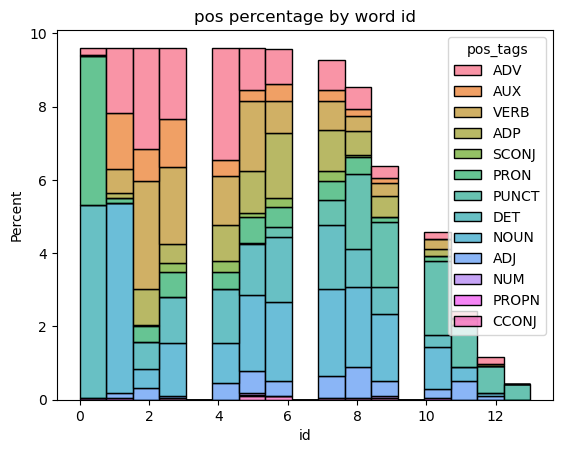

In [395]:
sns.histplot(pos_tags_df, x='id', hue='pos_tags', stat="percent", multiple='stack')
plt.title("pos percentage by word id")

Text(0.5, 1.0, 'content vs function percentage by word id')

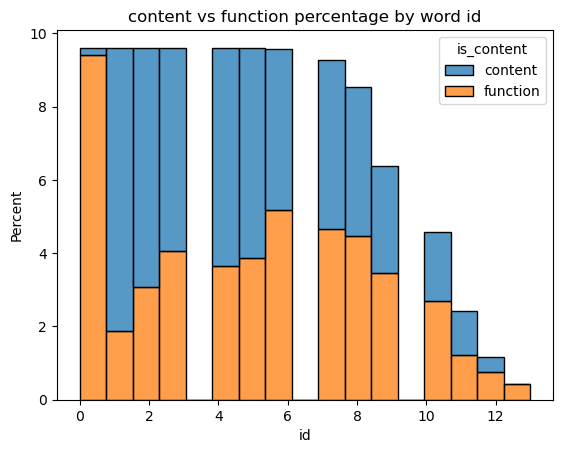

In [396]:
pos_tags_df['is_content'] = pos_tags_df['pos_tags'].apply(lambda x: content_function_word[x])

sns.histplot(pos_tags_df, x='id', hue='is_content', stat="percent", multiple='stack')
plt.title("content vs function percentage by word id")

# vocab

In [397]:
vocab, count = np.unique(np.concatenate(subset.lemmas.values), return_counts=True)

vocab_df = pd.DataFrame(vocab, columns=['word'])
vocab_df['counts'] = count

len(vocab_df.query("counts < 3")) / len(vocab_df)

0.2916666666666667

In [398]:
# vocab = list(set(subset['translation'].str.cat(sep=' ').split()))

# clean the words 
for i in range(len(vocab)):
    vocab[i] = vocab[i].lower()
    # index of ' in word
    if ("'" in vocab[i]):
        if (vocab[i].index("'") == 1):
            vocab[i] = vocab[i][2:]
    elif "'\u200b'" in vocab[i]:
        vocab[i] = vocab[i].replace("'\u200b'", "")
vocab = list(set(vocab))
vocab.sort()
vocab

['-',
 'accepter',
 'acheter',
 'aider',
 'aimer',
 'air',
 'aller',
 'ami',
 'amie',
 'animal',
 'anniversaire',
 'année',
 'appareil',
 'appeler',
 'apporter',
 'approche',
 'apprécier',
 'après',
 'après-midi',
 'arbitre',
 'arbre',
 'arriver',
 'assez',
 'attendre',
 'au',
 'au-dessus',
 "aujourd'hui",
 'aussi',
 'automne',
 'autre',
 'avant',
 'avec',
 'avoir',
 'bain',
 'bateau',
 'beau',
 'beaucoup',
 'bibliothèque',
 'bien',
 'boire',
 'bon',
 'bureau',
 'cadeau',
 'café',
 'calme',
 'canapé',
 'ce',
 'centre',
 'certain',
 'chaise',
 'championnat',
 'changement',
 'changer',
 'chaque',
 'charger',
 'chef',
 'cher',
 'chocolat',
 'choisir',
 'ci',
 'cinéma',
 'club',
 'collègue',
 'comme',
 'commercial',
 'communauté',
 'concurrence',
 'conduire',
 'confortable',
 'correctement',
 'couleur',
 'couple',
 'courir',
 'course',
 'cuisine',
 'dans',
 'de',
 'dehors',
 'demain',
 'dernier',
 'devant',
 'devoir',
 'dire',
 'dix',
 'donner',
 'doux',
 'durer',
 'décider',
 'décision',


In [399]:
print(f"num of unique words: {len(vocab)}")

num of unique words: 336


Text(0.5, 1.0, 'Character frequency all sentences')

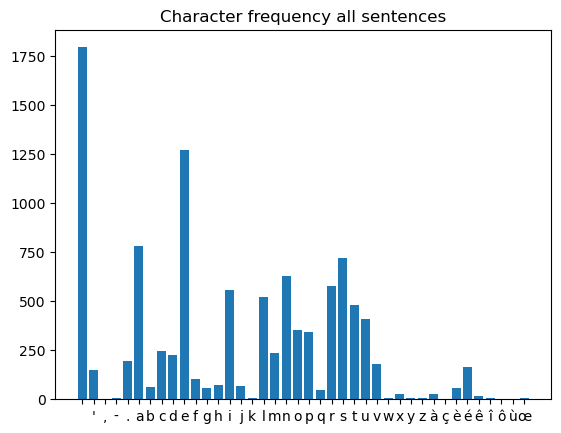

In [400]:
# get all char in sentence 
char = list("".join(subset.translation.str.cat(sep=' ')).lower())
unique_char, counts = np.unique(char, return_counts=True)

plt.bar(np.arange(len(unique_char)), counts, tick_label=unique_char)
plt.title('Character frequency all sentences')

# choose a subset of words 

In [401]:
len(set(vocab))

336

In [402]:
# words that are 4 char minimum, content words, check POS distribution, phonetic distribution, 50 words in total, 
vocab_filtered = [w for w in vocab if len(w) >=4]

Text(0.5, 1.0, 'POS distribution of words')

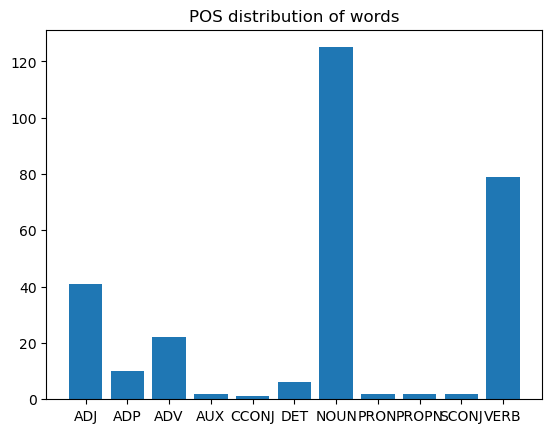

In [403]:
def get_pos(word): 
    doc = nlp(str(word))
    return doc[0].pos_

pos = [get_pos(w) for w in vocab_filtered]
np.unique(pos, return_counts=True)

plt.bar(np.unique(pos), np.unique(pos, return_counts=True)[1])
plt.title('POS distribution of words')

['content' 'function'] [267  25]


Text(0.5, 1.0, 'content vs functino word distribution')

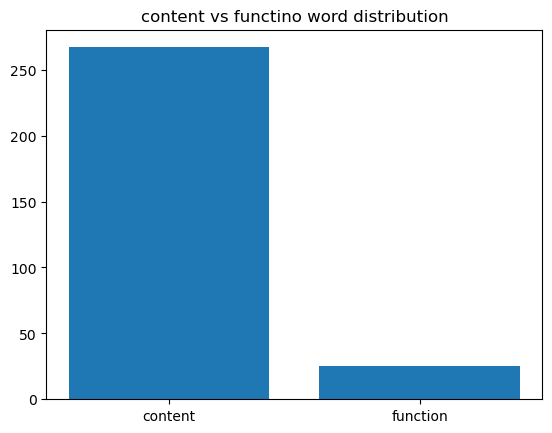

In [404]:

is_content = [content_function_word[p] for p in pos]

unique_c, counts = np.unique(is_content, return_counts=True)
print(unique_c, counts)

plt.bar(unique_c, counts)
plt.title("content vs functino word distribution")


In [405]:
# put words in df 
words = pd.DataFrame({'word': vocab_filtered, 'pos': pos, 'is_content': is_content})

# enrich 
words['phonemes'] = words['word'].apply(get_phonemes)
words['first_phone'] = words['phonemes'].apply(lambda x: x[0])
words.head()

,word,pos,is_content,phonemes,first_phone
0,accepter,VERB,content,"[a, k, s, ɛ, p, t, e]",a
1,acheter,VERB,content,"[a, ʃ, t, e]",a
2,aider,VERB,content,"[ɛ, d, e]",ɛ
3,aimer,VERB,content,"[ɛ, m, e]",ɛ
4,aller,VERB,content,"[a, l, e]",a


Text(0.5, 1.0, 'First phone distribution of words (length >= 4)')

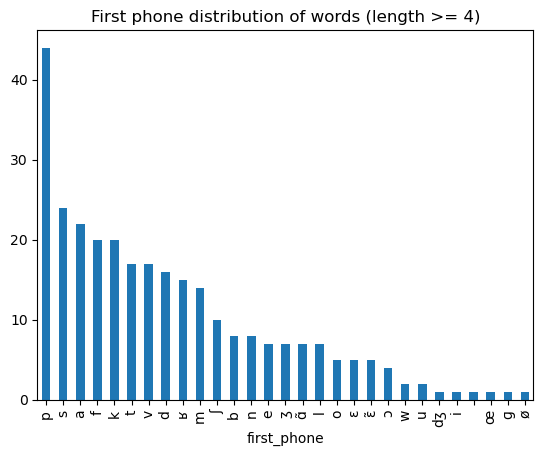

In [406]:
words.first_phone.value_counts().plot.bar()
plt.title('First phone distribution of words (length >= 4)')

In [407]:
infrequence_first_phones = words.first_phone.value_counts()[words.first_phone.value_counts() < 10].index

temp = words[~words.first_phone.isin(infrequence_first_phones)]
len(temp)

219

In [408]:
# remove words with symbols 
temp = temp[~temp.word.str.contains(r'[^\w\s]')]
temp = temp[~temp.word.str.contains(r'[\u200b]')]
temp = temp[temp.is_content == 'content']
len(temp)

198

In [421]:
sample_n = 20

word_path = Path("../text/selected_words_final.csv")

if word_path.exists():
    final_words = pd.read_csv(word_path)
else:
    final_words = temp.sample(sample_n)


# analysis of words selected for single word trials 

In [422]:
final_words

,word,pos,is_content,phonemes,first_phone
98,fatiguer,VERB,content,"[f, a, t, i, ɡ, e]",f
210,prêt,ADJ,content,"[p, ʁ, ɛ]",p
261,travers,NOUN,content,"[t, ʁ, a, v, ɛ, ʁ]",t
248,séjour,NOUN,content,"[s, e, ʒ, u, ʁ]",s
150,montagne,NOUN,content,"[m, ɔ̃, t, a, ɲ]",m
265,trop,ADV,content,"[t, ʁ, o]",t
277,voiture,NOUN,content,"[v, w, a, t, y, ʁ]",v
263,triste,ADJ,content,"[t, ʁ, i, s, t]",t
179,permission,NOUN,content,"[p, ɛ, ʁ, m, i, s, j, ɔ̃]",p
190,plus,ADV,content,"[p, l, y]",p


In [423]:
pd.concat([final_words]*4)

,word,pos,is_content,phonemes,first_phone
98,fatiguer,VERB,content,"[f, a, t, i, ɡ, e]",f
210,prêt,ADJ,content,"[p, ʁ, ɛ]",p
261,travers,NOUN,content,"[t, ʁ, a, v, ɛ, ʁ]",t
248,séjour,NOUN,content,"[s, e, ʒ, u, ʁ]",s
150,montagne,NOUN,content,"[m, ɔ̃, t, a, ɲ]",m
...,...,...,...,...,...
102,fier,ADJ,content,"[f, j, ɛ, ʁ]",f
20,attendre,VERB,content,"[a, t, ɑ̃, d, ʁ]",a
196,prendre,VERB,content,"[p, ʁ, ɑ̃, d, ʁ]",p
240,sortir,VERB,content,"[s, ɔ, ʁ, t, i, ʁ]",s


In [424]:
# make sure all words at root form 
def get_lemma(word): 
    doc = nlp(str(word))
    return doc[0].lemma_

final_words['lemma'] = final_words['word'].apply(get_lemma)
final_words

,word,pos,is_content,phonemes,first_phone,lemma
98,fatiguer,VERB,content,"[f, a, t, i, ɡ, e]",f,fatiguer
210,prêt,ADJ,content,"[p, ʁ, ɛ]",p,prêt
261,travers,NOUN,content,"[t, ʁ, a, v, ɛ, ʁ]",t,travers
248,séjour,NOUN,content,"[s, e, ʒ, u, ʁ]",s,séjour
150,montagne,NOUN,content,"[m, ɔ̃, t, a, ɲ]",m,montagne
265,trop,ADV,content,"[t, ʁ, o]",t,trop
277,voiture,NOUN,content,"[v, w, a, t, y, ʁ]",v,voiture
263,triste,ADJ,content,"[t, ʁ, i, s, t]",t,triste
179,permission,NOUN,content,"[p, ɛ, ʁ, m, i, s, j, ɔ̃]",p,permission
190,plus,ADV,content,"[p, l, y]",p,plus


In [425]:
(final_words.phonemes.values)

array([list(['f', 'a', 't', 'i', 'ɡ', 'e']), list(['p', 'ʁ', 'ɛ']),
       list(['t', 'ʁ', 'a', 'v', 'ɛ', 'ʁ']),
       list(['s', 'e', 'ʒ', 'u', 'ʁ']), list(['m', 'ɔ̃', 't', 'a', 'ɲ']),
       list(['t', 'ʁ', 'o']), list(['v', 'w', 'a', 't', 'y', 'ʁ']),
       list(['t', 'ʁ', 'i', 's', 't']),
       list(['p', 'ɛ', 'ʁ', 'm', 'i', 's', 'j', 'ɔ̃']),
       list(['p', 'l', 'y']), list(['v', 'w', 'a', 'ʁ']),
       list(['s', 'ə', 'k', 'ʁ', 'ɛ']),
       list(['s', 'ɔ', 's', 'j', 'e', 't', 'e']),
       list(['a', 'ʃ', 't', 'e']), list(['v', 'u', 'l', 'w', 'a', 'ʁ']),
       list(['f', 'j', 'ɛ', 'ʁ']), list(['a', 't', 'ɑ̃', 'd', 'ʁ']),
       list(['p', 'ʁ', 'ɑ̃', 'd', 'ʁ']),
       list(['s', 'ɔ', 'ʁ', 't', 'i', 'ʁ']),
       list(['v', 'w', 'a', 'z', 'ɛ̃'])], dtype=object)

Text(0.5, 1.0, 'phoneme frenquency in words')

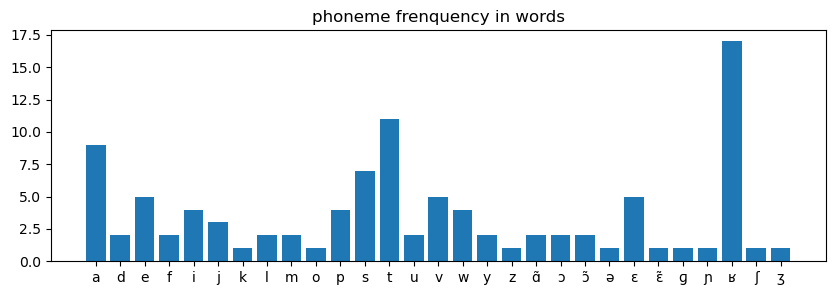

In [426]:
unique_phonemes, counts = np.unique(np.hstack(final_words.phonemes.values), return_counts=True)

plt.figure(figsize=(10, 3))
plt.bar(np.arange(len(unique_phonemes)), counts, tick_label=unique_phonemes)
plt.title("phoneme frenquency in words")

Text(0.5, 1.0, 'distribution of n syllable in words')

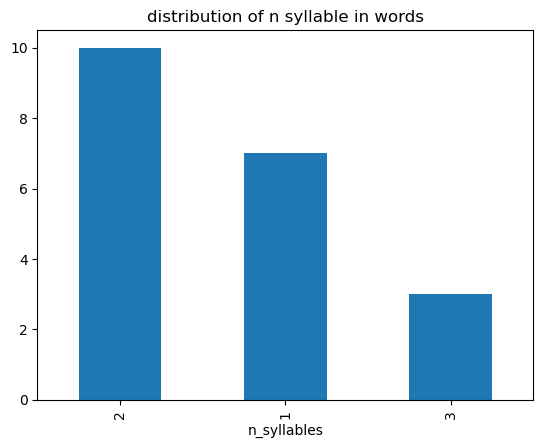

In [427]:
def n_syllables(words): 
    doc = nlp(str(words))
    return doc[0]._.syllables_count

final_words['n_syllables'] = final_words['word'].apply(n_syllables)

final_words.n_syllables.value_counts().plot.bar()
plt.title('distribution of n syllable in words')

Text(0.5, 1.0, 'distribution of n_char of words')

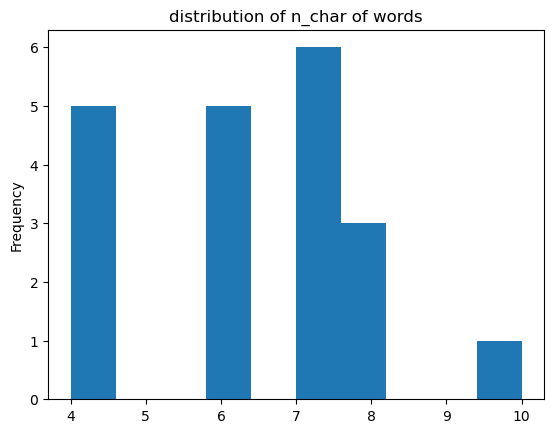

In [428]:
final_words.word.apply(len).plot.hist()
plt.title("distribution of n_char of words")

Text(0.5, 1.0, 'First phone distribution of final words')

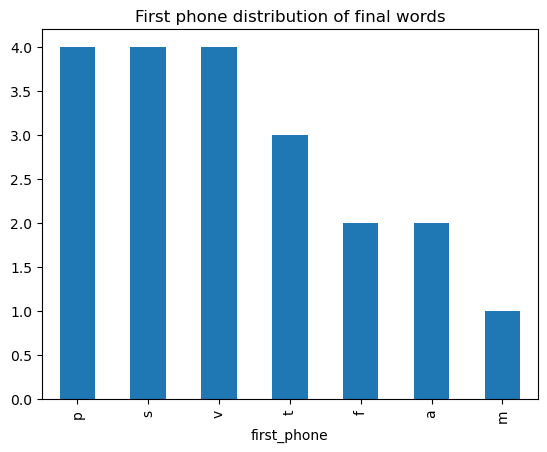

In [429]:
final_words.first_phone.value_counts().plot.bar()
plt.title('First phone distribution of final words')

Text(0.5, 1.0, 'POS distribution of final words')

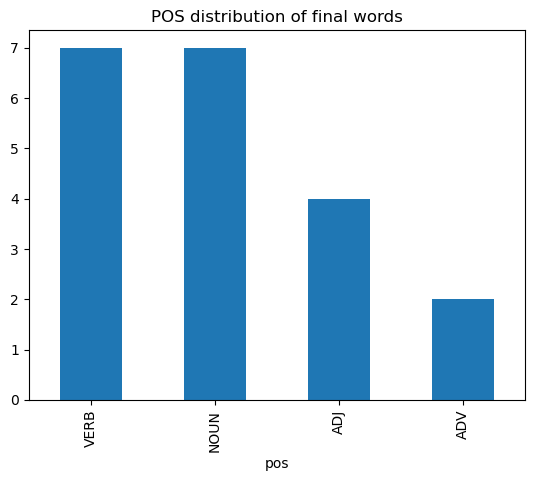

In [430]:
final_words.pos.value_counts().plot.bar()
plt.title('POS distribution of final words')

In [431]:
final_words.to_csv('../text/selected_words_final.csv', index=False)